In [1]:
import gpytorch
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import FloatSlider, interact
from scipy.optimize import minimize
from types import SimpleNamespace as Namespace
from scipy.stats import multivariate_normal

In [2]:
import gp
import utils

In [3]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Dummy generative model

In [4]:
def f(x, add_noise=True):
    
    y = torch.sin(x * (2 * np.pi))
    if add_noise:
        y += torch.randn(x.size()) * np.sqrt(0.04)
        
    return y

# Reduce uncertainty

Objective: minimize $-$ SD 

In [6]:
class ReduceUncertainty:
    
    def __init__(self):
        self.gp = gp.GP()

    def x_new(self, n_warmup=1000):
        
        def objective(x):
            pred = self.gp.predict(torch.from_numpy(x).float())
            return - pred.stddev.numpy()
        
        x_warmup = np.random.random(n_warmup)
        y_warmup = - objective(x_warmup)
        bounds = [[0., 1.]]
        best_x = x_warmup[np.argmax(y_warmup)]
        res = minimize(objective,
               x0=best_x,
               bounds=bounds,
               method="L-BFGS-B")
        x_max = torch.from_numpy(res.x).float()
        return x_max
    
    def run(self, f, n_warm_up=5, n_epochs=25):
        warmup_x = torch.rand(n_warm_up)
        warmup_y = f(warmup_x)
        train_x = warmup_x.clone()
        train_y = warmup_y.clone()
        for _ in range(n_epochs):
            self.gp.fit(train_x, train_y)
            x_new = self.x_new()
            y_new = f(x_new)
            train_x = torch.cat((train_x, x_new), 0)
            train_y = torch.cat((train_y, y_new), 0)
            
            if torch.allclose(train_x[-1], train_x[-2]):
                print(f"Converged at iter {_}")
                break

        train_x, train_y = train_x[n_warm_up:], train_y[n_warm_up:]
        return Namespace(
            train_x=train_x, train_y=train_y, 
            warmup_x=warmup_x, warmup_y=warmup_y)
        
m = ReduceUncertainty()
m_res = m.run(f)

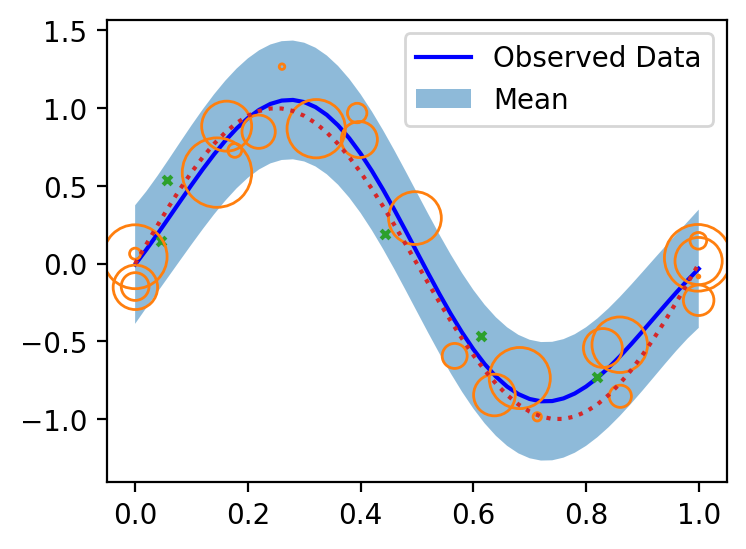

In [11]:
test_x = torch.linspace(0, 1, 51)
train_x, train_y = m_res.train_x, m_res.train_y
warmup_x, warmup_y = m_res.warmup_x, m_res.warmup_y

pred = m.gp.predict(test_x)
ax = utils.gp_plot(pred, train_x=None, train_y=None, test_x=test_x)
# Plot warming up as crosses
ax.scatter(warmup_x.numpy(), 
           warmup_y.numpy(), 
           marker="x", 
           c='C2', 
           zorder=2, 
           s=10)
# Plot training data as dots
ax.scatter(train_x.numpy(), 
           train_y.numpy(), 
           facecolors='none', 
           color='C1', 
           zorder=2, 
           s=(1+ np.arange(len(train_x)))**2)

ax.plot(test_x.numpy(), f(test_x, add_noise=False), color='C3', linestyle=":");